<a href="https://colab.research.google.com/github/fpinell/hands_on_python_for_ds/blob/main/notebooks/phd/4_deep_learning_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on Python for Data Science


### PhD 2022-2023

#### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2022/2023<br/>
May, 30 2023

# Outline

- Introduction to RNN
- Gated Recurrent Unit (GRU) 
- Long Short-Term Memory (LSTM)



# Sequences
- Last time we applied Deep Learning Networks (CNN) to images
- Another type of data comes from *an ordered sequence of data points sharing a label*   
- This particular structure has a single dimension
- This structure can be exploited by Recurrent Neural Networks and many variants as well as 1D Convolutional Neural Networks. 
- Example of sequence data: 
  - Text (NLP)
  - Time-series
    + Trajectories
    + Audio 
    + Sensors data
    + etc. 

    

# Recurrent Neural Networks (RNN)
- RNNs take advantage of the underlying structure of the data:
  - The order of the data points 
- RNN can be used for classification tasks, predictions, regression, etc. 

How they work schematically?

1. Data points are sequentially presented to the newtork 
2. The data points modify the internal (so called **hidden**) state 
3. The final hidden state is a *representation* of the full sequence

--> RNNs are all about producing a **hidden state** that best represents a **sequence** 

## Hidden state
The hidden state is a *simply* a **VECTOR** and its size is up to us. This means that we need to specify the number of the **Hidden dimension** (as for the CNN we need to specify the size of the kernel)

With these dimensions we specify the size of the vector that represents the Hidden State

## RNN Architecture 

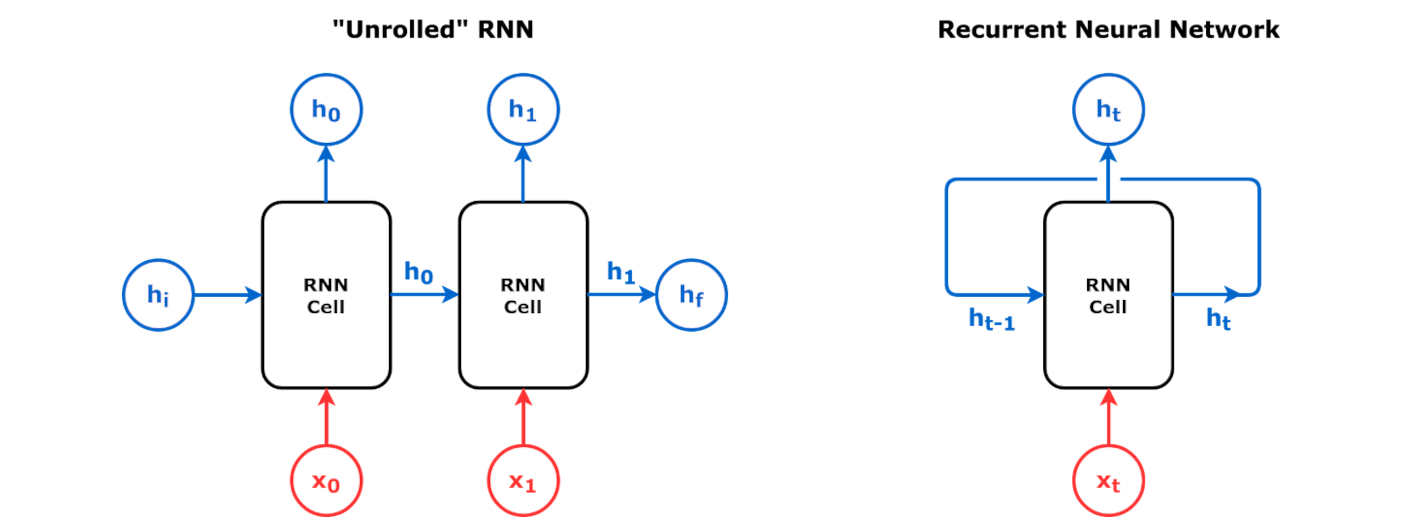

### RNN Architecture (2)

1.   There is a initial Hidden State ($h_i$): it represents the state for the empty sequence;
2.   A RNN cell takes two inputs: The *Hidden State* and a *Data Point* of the Sequence ($x_0$ and $x_1$)
  - The hidden state represents the state of the sequence *so far*
  - The two data points are two points of our input sequences
3. Two inputs are used to PRODUCE a new Hidden State (i.e., $h_0$ for the first data point)
4. The new hidden state is both the output of the current step and one of the input of the next step (see where $h_0$ is on the graph on the left)
5. If there is yet another data point in the sequence, 
  - **THEN** we go back to step #2
  - **ELSE** the last hidden state (i.e., $h_1$) is the final hidden state of the whole RNN 



### RNN Architecture (3)

In reality the *unrolled* representation is misleading:
- There is only one cell 
  - It learns a particular set of weights and biases
  - These will transform the inputs exactly the same way in every step of the sequence

### RNN Architecture (4)

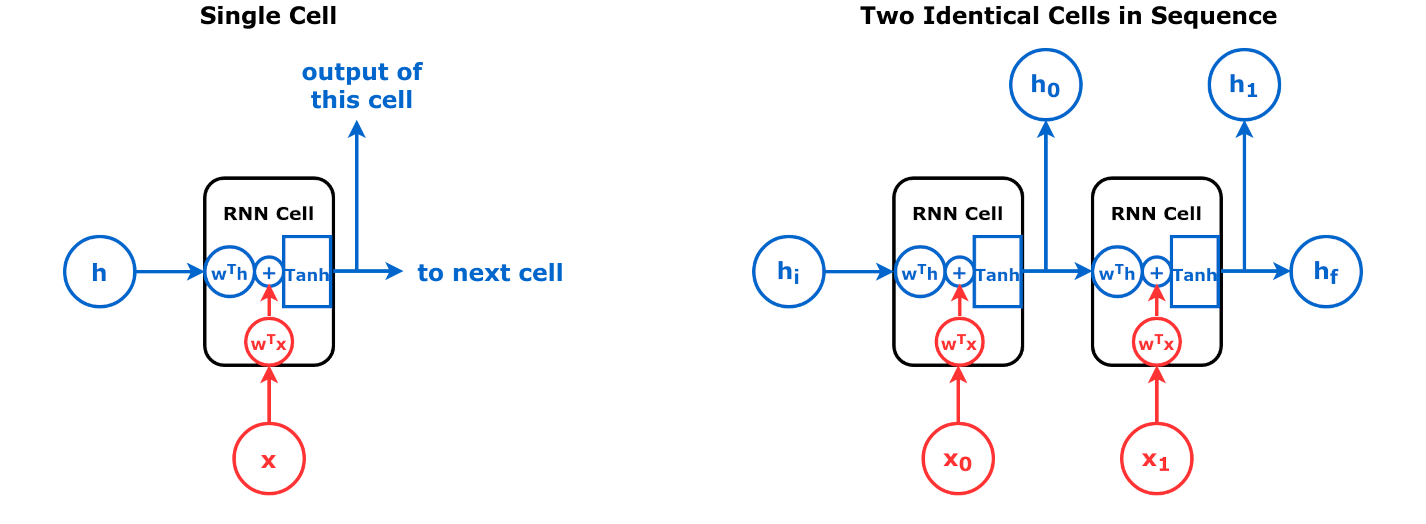

On the left figure we have a Single RNN Cell

1. A linear layer to transform the hidden state (blue)
2. A linear layer to transform the data point (red)
3. An activation function applied to the SUM of both transformed inputs

Linear Layers transform the hidden state and the input.

The updated hidden state is both the output of this particular cell and the input of the "*next*" cell. 

But there is not another **CELL** is the same cell over and over again (see right figure above). What does it mean? 

- In the second step of the sequence:
  - The updated hidden state will run through the very same linear layer as the first hidden state
  - The second data point goes through the very same linear layer as the first data point


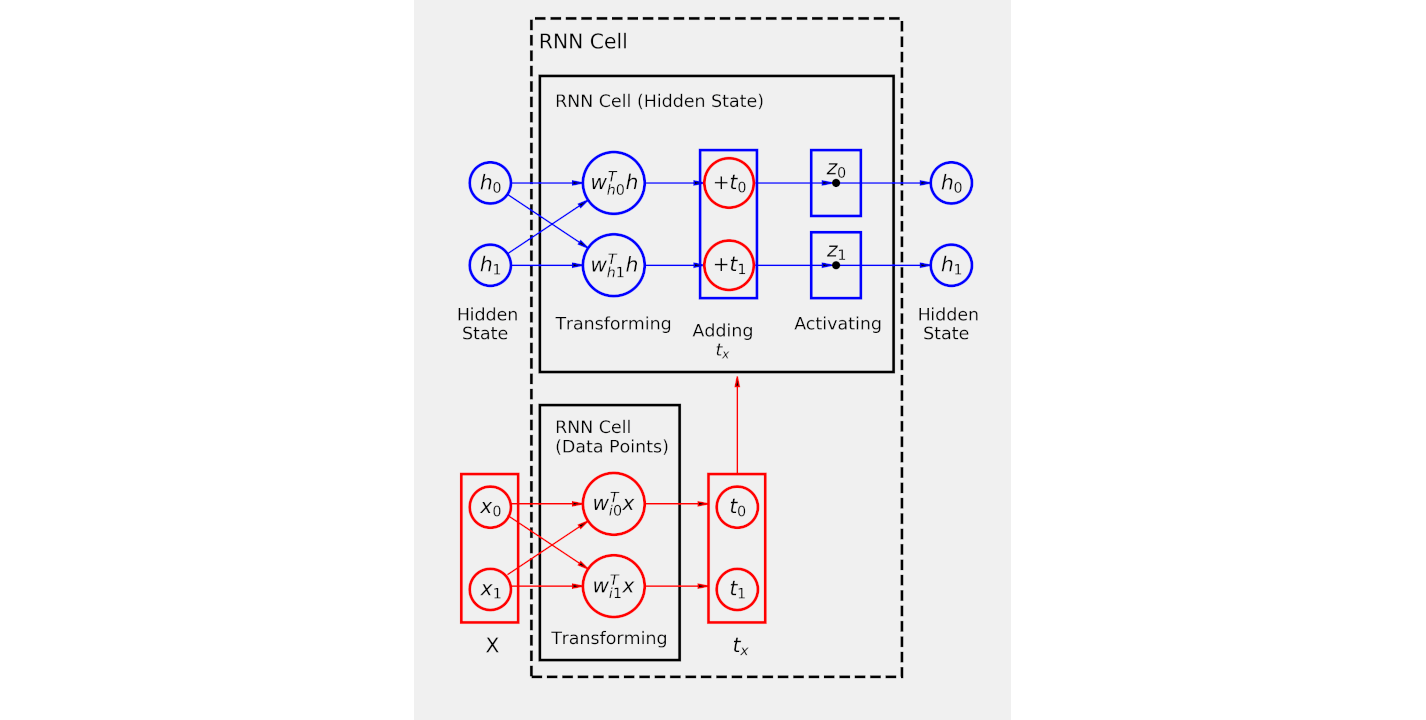


If we consider **2 Hidden Dimensions** the RNN looks like the figure above

- Two neurons are transforming the hidden state (blue)
- $N$ RED Neurons transforming the data points are the same number of the hidden dimensions, the results of these two transformation need to be added together
- The data points can have a different dimension (in our example we have the input size equal to two but just for demonstration purposes)  

### Some example

In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils


In [49]:
import numpy as np

def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

In [56]:
points, directions = generate_sequences(n=128, seed=13)

In [51]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])


 
```
weight_ih, bias_ih
```
```i``` stands for input, they represent the tensors of the RED neurons 

```
weight_hh, bias_hh
```
```h``` stands for hidden, they represent the tensors of the BLUE neurons 


In [52]:
linear_input = nn.Linear(n_features, hidden_dim)
linear_hidden = nn.Linear(hidden_dim, hidden_dim)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [53]:
'''
The initial hidden state representing the empty sequence.
It is initialized with all zeros (torch.zeros)
'''
initial_hidden = torch.zeros(1, hidden_dim)
initial_hidden

tensor([[0., 0.]])

In [54]:
'''
Following the RNN architecture, we apply the hh linear layer 
to  transform the hidden state
--> BLUE NEURONS
'''

th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [57]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

In [58]:
tx = linear_input(X[0:1])
tx

tensor([[0.7712, 1.4310]], grad_fn=<AddmmBackward0>)

In [59]:
adding = th + tx
adding

tensor([[0.4146, 1.1405]], grad_fn=<AddBackward0>)

In [60]:
torch.relu(adding)

tensor([[0.4146, 1.1405]], grad_fn=<ReluBackward0>)

In [61]:
rnn_cell(X[0:1])

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

We need to remember that the RNN has two inputs:
  - The data points
  - The hidden state

We need to loop over the data points and provide the updated hidden state at each step: 
 

In [62]:
hidden = torch.zeros(1, hidden_dim)
for i in range(X.shape[0]):
    out = rnn_cell(X[i:i+1], hidden)
    print(out)
    hidden = out

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)
tensor([[ 0.4347, -0.0481]], grad_fn=<TanhBackward0>)
tensor([[-0.1521, -0.3367]], grad_fn=<TanhBackward0>)
tensor([[-0.5297,  0.3551]], grad_fn=<TanhBackward0>)


The ```tensor([[-0.5297,  0.3551]])``` is the last hidden state and it is the representation of the full sequence

Looping over the data points in a sequence can require a lot of work and time...

Instead of a RNN cell we can use **RNN layer** that 
- Takes care of the hidden state no matter how long the input sequence is
- We need to take care about the **shapes** of the **INPUTS** and **OUTPUTS**

 - ```input_size```: is the number of features in each data point of the sequence
 
 - ```hidden_size```: is the number of hidden dimensions 


In [63]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

Another input parameter: 

- ```batch_first```: if ```True``` **ONLY** the the input and output tensors are provided as (batch, seq, feature)

- ONLY --> the hidden state will never be batch first 

### Shapes
**INPUTS**
- The input tensor containing the sequence you want to run through the RNN: 
  - The **Default** shape is **sequence-first** (sequence  length, batch size, number of features) (**L,N,F**)
  - Choosing ```batch_first = True``` (**N,L,F**), this is what we get from a data loader

- The initial hidden state
  - tensor with shape (**1,N,H**)


**OUTPUTS**
- The output tensor contains the hidden states corresponding to the outpus of its RNN cells for all steps in the sequence: 
  - Output sensor shape (**L,N,H**)
  - With ```batch_first``` it permute the first to dimensions obtaining (**N,L,H**)

- The final hidden state follows the same rules the the initial hidden state


In [64]:
'''
Let's create a batch with 3 sequences with 4 data points, each data point
is described by 2 coordinates
The shape is (3,4,2) -> batch_first (N,L,F)
Similarly to what we get from a data loader
'''

batch = torch.as_tensor(np.array(points[:3])).float()
batch.shape

torch.Size([3, 4, 2])

In [65]:
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

In [66]:
torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

The last element of the output IS the final hidden state, let's check

In [67]:
(out[-1] == final_hidden).all()

tensor(True)

In [68]:
print(out[-1])
print(final_hidden)

tensor([[-0.5297,  0.3551],
        [ 0.3142, -0.1232],
        [-0.2095,  0.4354]], grad_fn=<SelectBackward0>)
tensor([[[-0.5297,  0.3551],
         [ 0.3142, -0.1232],
         [-0.2095,  0.4354]]], grad_fn=<StackBackward0>)


In [69]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch.shape

torch.Size([3, 4, 2])

In [70]:
torch.manual_seed(19)
rnn_batch_first = nn.RNN(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
out, final_hidden = rnn_batch_first(batch)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

Two distinct shapes as result: 
- batch_first (N,L,H) for the output
- sequence first (1,N,H) for the final hidden state

This might lead to confusion... but... 
Most of the time we need to handle the input, and data loaders typically provide batch_first shapes, therefore we will use ```batch_first = True```.

### The model

In [76]:
test_points, test_directions = generate_sequences(seed=19)
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [100]:
test_directions

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1])

In [77]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

We want to understand if the squares are drawn in a **clock-wise** or **anticlock-wise** direction

1. We use a simple RRN to obtain the final hidden state
2. The final hidden state represents the full sequence
3. Use it to train a classifier layer


In [78]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [88]:
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [89]:
epochs = 100
losses = []
for i in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_dim),
                        torch.zeros(1, 1, model.hidden_dim))

        y_pred = model(seq)

        single_loss = loss(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.70908552
epoch:  26 loss: 0.45952684
epoch:  51 loss: 0.52138335
epoch:  76 loss: 0.10545763
epoch:  99 loss: 0.0324312560


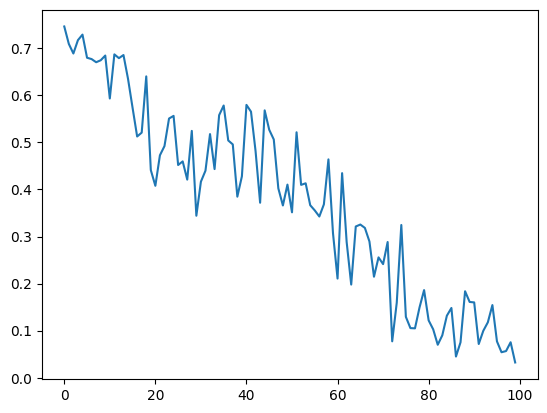

In [92]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [101]:
def correct(model, x, y, threshold=.5):
      model.eval()
      yhat = model(x)
      y
      model.train()

      # We get the size of the batch and the number of classes 
      # (only 1, if it is binary)
      n_samples, n_dims = yhat.shape
      if n_dims > 1:        
          # In a multiclass classification, the biggest logit
          # always wins, so we don't bother getting probabilities

          # This is PyTorch's version of argmax, 
          # but it returns a tuple: (max value, index of max value)
          _, predicted = torch.max(yhat, 1)
      else:
          n_dims += 1
          # In binary classification, we NEED to check if the
          # last layer is a sigmoid (and then it produces probs)
          if isinstance(model, nn.Sequential) and \
              isinstance(model[-1], nn.Sigmoid):
              predicted = (yhat > threshold).long()
          # or something else (logits), which we need to convert
          # using a sigmoid
          else:
              predicted = (torch.sigmoid(yhat) > threshold).long()

      # How many samples got classified correctly for each class
      result = []
      for c in range(n_dims):
          n_class = (y == c).sum().item()
          n_correct = (predicted[y == c] == c).sum().item()
          result.append((n_correct, n_class))
      return torch.tensor(result)

In [106]:
final_results = []
for x, y in test_loader:
  res = correct(model, x,y)
  final_results.append(res)

In [104]:
final_results

[tensor([[ 6,  6],
         [10, 10]]),
 tensor([[ 5,  5],
         [11, 11]]),
 tensor([[ 4,  4],
         [12, 12]]),
 tensor([[6, 7],
         [9, 9]]),
 tensor([[8, 8],
         [8, 8]]),
 tensor([[8, 8],
         [8, 8]]),
 tensor([[ 5,  6],
         [10, 10]]),
 tensor([[8, 9],
         [7, 7]])]

# Gated Recurrent Units (GRUs)

- What if the previous hidden state contains more information than the newly computed one? 
- What if the data point adds more information than the previous hidden state had? 

The answer is: 
- Gated Recurrent Units
  - Weighted average between **new** and **old** hidden states ($z$ parameter to control the weights)
  - Scale the hidden state ($t_h$) by a factor $r$ before adding to $t_n$, and this will be multiplicated by ($1-z$)
  - $r$: *reset* gate, values between 0 and 1
  - $z$ *update* gate, values between 0 and 1
  - Every gate produces a vector of values with a size corresponding to the number of hidden dimensions
  - Since gates produce vectors, operations involving them are element-wise multiplications.

$$
\Large
\begin{array}
&\text{RNN}: &h'&=\text{tanh}(t_h+t_x)
\\
\text{GRU}: &h'&=\underbrace{\underbrace{\text{tanh}(\color{red}{r}*t_{hn}+t_{xn})}_{n}*\color{#0066CC}{(1-z)} + \color{gray}{h}*\color{#0066CC}{z}}_{\text{weighted average of }n\text{ and }h}
\end{array}
$$

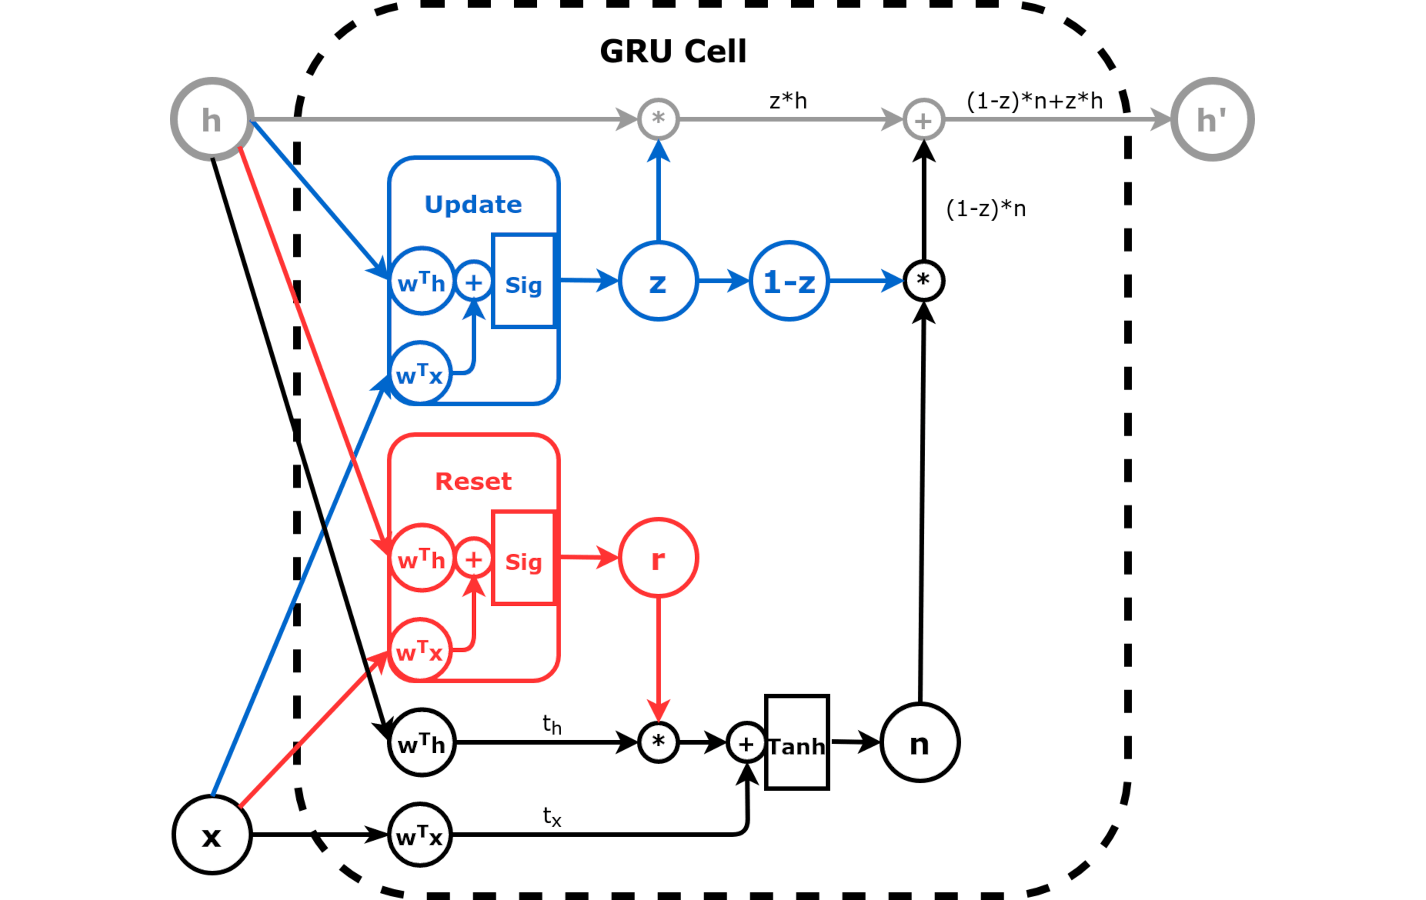

## Code

In [107]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
gru_cell = nn.GRUCell(input_size=n_features, hidden_size=hidden_dim)
gru_state = gru_cell.state_dict()
gru_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889]])),
             ('weight_hh',
              tensor([[-0.4167, -0.4352],
                      [-0.2060, -0.3989],
                      [-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691]])),
             ('bias_ih',
              tensor([-0.4316,  0.4019,  0.1222, -0.4647, -0.5578,  0.4493])),
             ('bias_hh',
              tensor([-0.6800,  0.4422, -0.3559, -0.0279,  0.6553,  0.2918]))])

In [108]:
Wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
Wh, bh = gru_state['weight_hh'], gru_state['bias_hh']

print(Wx.shape, Wh.shape)
print(bx.shape, bh.shape)

torch.Size([6, 2]) torch.Size([6, 2])
torch.Size([6]) torch.Size([6])


In [109]:
Wxr, Wxz, Wxn = Wx.split(hidden_dim, dim=0)
bxr, bxz, bxn = bx.split(hidden_dim, dim=0)

Whr, Whz, Whn = Wh.split(hidden_dim, dim=0)
bhr, bhz, bhn = bh.split(hidden_dim, dim=0)

Wxr, bxr

(tensor([[-0.0930,  0.0497],
         [ 0.4670, -0.5319]]),
 tensor([-0.4316,  0.4019]))

In [110]:
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()    
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_hidden, lin_input

r_hidden, r_input = linear_layers(Wxr, bxr, Whr, bhr) # reset gate - red
z_hidden, z_input = linear_layers(Wxz, bxz, Whz, bhz) # update gate - blue
n_hidden, n_input = linear_layers(Wxn, bxn, Whn, bhn) # candidate state - black

In [111]:
def reset_gate(h, x):
    thr = r_hidden(h)
    txr = r_input(x)
    r = torch.sigmoid(thr + txr)
    return r  # red
    
def update_gate(h, x):
    thz = z_hidden(h)
    txz = z_input(x)
    z = torch.sigmoid(thz + txz)
    return z  # blue
    
def candidate_n(h, x, r):
    thn = n_hidden(h)
    txn = n_input(x)
    n = torch.tanh(r * thn + txn)
    return n  # black

In [112]:
initial_hidden = torch.zeros(1, hidden_dim)
X = torch.as_tensor(points[0]).float()
first_corner = X[0:1]

In [113]:
r = reset_gate(initial_hidden, first_corner)
r

tensor([[0.2387, 0.6928]], grad_fn=<SigmoidBackward0>)

In [114]:
n = candidate_n(initial_hidden, first_corner, r)
n

tensor([[-0.8032, -0.2275]], grad_fn=<TanhBackward0>)

In [115]:
z = update_gate(initial_hidden, first_corner)
z

tensor([[0.2984, 0.3540]], grad_fn=<SigmoidBackward0>)

In [116]:
h_prime = n*(1-z) + initial_hidden*z
h_prime

tensor([[-0.5635, -0.1470]], grad_fn=<AddBackward0>)

In [117]:
gru_cell(first_corner)

tensor([[-0.5635, -0.1470]], grad_fn=<AddBackward0>)

In [118]:
class SquareModelGRU(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple GRU
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)        

In [119]:
torch.manual_seed(21)
model = SquareModelGRU(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [120]:
epochs = 100
losses = []
for i in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_dim),
                        torch.zeros(1, 1, model.hidden_dim))

        y_pred = model(seq)

        single_loss = loss(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.69928366
epoch:  26 loss: 0.04697569
epoch:  51 loss: 0.03366459
epoch:  76 loss: 0.00736064
epoch:  99 loss: 0.0052382303


In [121]:
final_results = []
for x, y in test_loader:
  res = correct(model, x,y)
  final_results.append(res)

In [124]:
final_results

[tensor([[ 6,  6],
         [10, 10]]),
 tensor([[ 5,  5],
         [11, 11]]),
 tensor([[ 4,  4],
         [12, 12]]),
 tensor([[7, 7],
         [9, 9]]),
 tensor([[8, 8],
         [8, 8]]),
 tensor([[8, 8],
         [8, 8]]),
 tensor([[ 6,  6],
         [10, 10]]),
 tensor([[9, 9],
         [7, 7]])]

# Long Short-Term Memory (LSTM)